# This code file is divided into 3 main parts:
#### Part 1: Network Analysis (Use of NetworkX)
#### Part 2: Data Manipulation and Preprocessing (Use of Pandas and other libraries)
#### Part 3: Clustering and correlation analysis (Use of sci-kit learn)

# Importing key libraries

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import pylab as pyl
import matplotlib.mlab as mlab
import networkx as nx
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from networkx.drawing.nx_agraph import graphviz_layout
from networkx import community
%matplotlib inline

# Reading Datasets

In [6]:
nodes = pd.read_csv('nodes.csv')  #Reading in the nodes dataset

In [703]:
edges = pd.read_csv('edges.csv')  #Reading in the edges dataset

# Part 1: Network Analysis

In [704]:
#Creating a new network
G = nx.Graph()

In [709]:
# Making a global network of all nodes and edges
    
for i in range(len(edges['fromNode'])):
    G.add_edge(edges['fromNode'][i],edges['toNode'][i],weight=edges['strength'][i])

In [710]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 9628\nNumber of edges: 6655\nAverage degree:   1.3824'

###### Finding the biggest subnetworks in the global network G

In [713]:
#Finding the biggest subnetworks in the global network G

connections=[]
for i in range(4866):
    connections.append((i+1,len(nx.node_connected_component(G, i+1))))
    
print(sorted(connections,reverse=True, key=lambda x: x[1])[:70])

[(19, 88), (120, 88), (284, 88), (798, 88), (871, 88), (925, 88), (1425, 88), (1509, 88), (1510, 88), (1516, 88), (1534, 88), (1540, 88), (1549, 88), (1563, 88), (1619, 88), (1656, 88), (1696, 88), (1703, 88), (1795, 88), (1815, 88), (1835, 88), (1838, 88), (1846, 88), (2338, 88), (2357, 88), (2759, 88), (2811, 88), (2926, 88), (2928, 88), (2931, 88), (2949, 88), (2959, 88), (2961, 88), (2971, 88), (2995, 88), (3005, 88), (3033, 88), (3101, 88), (3148, 88), (3153, 88), (3326, 88), (3354, 88), (3552, 88), (4249, 88), (4714, 88), (4766, 88), (290, 56), (789, 56), (790, 56), (1192, 56), (2000, 56), (2348, 56), (2388, 56), (2540, 56), (3203, 56), (3358, 56), (3797, 56), (3802, 56), (3942, 56), (3976, 56), (4129, 56), (4330, 56), (4505, 56), (4530, 56), (4536, 56), (4702, 56), (18, 44), (252, 44), (1813, 44), (1814, 44)]


###### Finding the most central nodes in the global network G

In [181]:
#Finding the most central nodes in the global network G
a = nx.betweenness_centrality(G)

def highest_centrality(cent_dict):
     """Returns a tuple (node,value) with the node
 with largest value from Networkx centrality dictionary."""
     # Create ordered tuple of centrality data
     cent_items=[(b,a) for (a,b) in cent_dict.items()]
     # Sort in descending order
     cent_items.sort()
     cent_items.reverse()
     return tuple((cent_items[0:7]))
highest_centrality(a)

centrality = [a[i] for i in range(1,9629)]

nodes['centrality'] = centrality

((4.4771291997806714e-05, 2926),
 (4.351233771242961e-05, 2928),
 (4.107787982573454e-05, 5030),
 (3.153140933033178e-05, 6487),
 (2.0718790525064006e-05, 790),
 (2.0060537284423953e-05, 2931),
 (1.8323180370603494e-05, 3148))

###### Creating the 'size of your network' column

In [239]:
#Creating the 'size of your network' column

size_of_network = []
for i in range(1,9629):
    size_of_network.append(len(nx.node_connected_component(G, i)))
    
nodes['network_size'] = size_of_network

###### Creating and visualizing subgraphs by providing node names

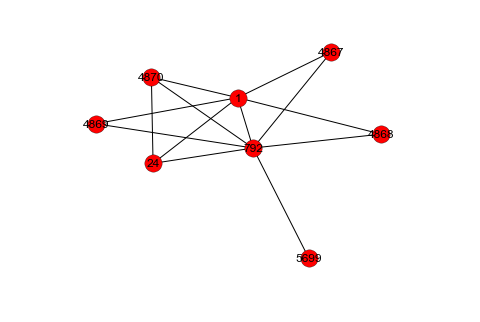

In [715]:
def create_subgraph(G,sub_G,start_node): #This function creates subgraphs for each node
    sub_G.add_node(start_node)
    for n in G.neighbors_iter(start_node):
        if n not in sub_G.neighbors(start_node):
            sub_G.add_path([start_node,n])
            create_subgraph(G,sub_G,n)

sub_G = nx.Graph()
create_subgraph(G,sub_G,1)
nx.draw(sub_G,with_labels = True)
plt.show()


###### Building local networks within each zip code

In [409]:
# This cell builds separate local networks for each zipcode and stores these networks in a list.
zip_networks = []
i=0
for zipcodes in (csv.groupby('zip')):
    G1=nx.Graph()
    for j in range(len(zipcodes[1])):
        G1.add_edge(zipcodes[1]['fromNode'][i],zipcodes[1]['toNode'][i],weight = zipcodes[1]['strength'][i])
        i+=1
    zip_networks.append(G1)

###### Getting the average size of all networks in each zip

In [685]:
#Average size of all networks in each zip
network_sizes = []
for network in zip_networks:
    size=[]
    sub_graphs = nx.connected_component_subgraphs(network)
    for i, sg in enumerate(sub_graphs):
        size.append(len(sg.nodes()))
    network_sizes.append(mean(sorted(size,reverse=True)))

###### Getting the average size of top 20 networks in each zip

In [683]:
#Average size of top 20 networks in each zip
network_sizes = []
for network in zip_networks:
    size=[]
    sub_graphs = nx.connected_component_subgraphs(network)
    for i, sg in enumerate(sub_graphs):
        size.append(len(sg.nodes()))
    network_sizes.append(mean(sorted(size,reverse=True)[:20]))

###### Getting the average 'total strength' of all networks in each zip (Average number of shopping trips in networks)

In [687]:
#Average 'total strengths' of all networks in each zip

network_weights = []
for item in zip_networks:
    weight = []
    sub_graphs = nx.connected_component_subgraphs(item)
    for i, sg in enumerate(sub_graphs):
        sum_=0
        for item1 in sg.edges(data='weight'):
            sum_+=(item1[2])
        weight.append(sum_)
    network_weights.append(mean(weight))
    

###### Getting the average 'total strength' of all networks in each zip (Average number of shopping trips in networks)

In [689]:
#Average 'total strengths' of top 20 networks in each zip

network_weights = []
for item in zip_networks:
    weight = []
    sub_graphs = nx.connected_component_subgraphs(item)
    for i, sg in enumerate(sub_graphs):
        sum_=0
        for item1 in sg.edges(data='weight'):
            sum_+=(item1[2])
        weight.append(sum_)
    network_weights.append(mean(sorted(weight,reverse=True)[:20]))
    

# Part 2: Data Manipulation and Preprocessing

In [717]:
#Grouping the edges dataset based on source nodes
grouped_source_nodes = edges.groupby('fromNode')    

In [720]:
#Grouping the edges dataset based on destination nodes
grouped_destination_nodes = edges.groupby('toNode')    

In [721]:
#Grouping the edges dataset based on zip codes
grouped_zips = edges.groupby('zip')

### Feature Generation

###### Feature: Getting the names of all friends for each node

In [568]:
#Getting all the friends for each node

list_new=[]

for item in grouped:
    list_new.append((grouped_source_nodes[1]['toNode']).tolist())

list_new = list_new + [0]*(9628-4866) 

nodes['friends_names'] = list_new

###### Feature: Getting the 'total number of shopping trips' with friends for each node (We call it 'weight')

In [718]:
list1 = [0]*len(nodes['node'])

for item in set(edges['fromNode']):
    list1[item-1]=grouped_source_nodes['strength'].sum()[item]
    
nodes['weight']=list1

###### Feature: Getting the number of friends for each node (We call it 'friends')

In [566]:
list2 = [0]*len(nodes['node'])

for item in set(edges['fromNode']):
    list2[item-1]=grouped_source_nodes['toNode'].count()[item]
    
nodes['friends']=list2

###### Feature: Getting the average strength of relationships for each node (We call it 'average_strength')

In [719]:
list3 = [0]*len(nodes['node'])

for item in set(edges['fromNode']):
    list3[item-1]=grouped_source_nodes['strength'].mean()[item]
    
nodes['average_strength']=list3

###### Feature: Getting zip code for each node (We call it 'zips')

In [723]:
#Getting list of nodes in each zip

list_zips = list(set(nodes['zips']))
list_nodes = []

for item in grouped_zips['fromNode']:
    list_nodes.append(list(set(item[1])))
    
a = zip(list_zips,list_nodes)
zips = [0]*len(nodes)
for pair in a:
    for item in pair[1]:
        zips[item-1] = pair[0]
        
nodes['zips']=zips

###### Feature: Getting 'Average revenue of friends', 'Total revenue of friends' and 'Revenue in hand' for each node

In [724]:
average_friends_revenues = [0]* len(nodes)
total_friends_revenues = [0]*len(nodes)
revenue_in_hand = [0]*len(nodes)
for i,friends in enumerate(nodes['friends_names']):
    friends_revenues=[]
    if type(friends)!=type([1,2]):
        continue
    for friend in friends:
        friends_revenues.append(nodes['revenueYear'][friend-1])
    average_friends_revenues[i] = np.mean(friends_revenues)
    total_friends_revenues[i] = np.sum(friends_revenues)
    revenue_in_hand[i] = np.sum(friends_revenues) + nodes['revenueYear'][i]

nodes['average_friends_revenues'] = average_friends_revenues    
nodes['total_friends_revenues'] = total_friends_revenues
nodes['revenue_in_hand'] = revenue_in_hand

###### Feature: Getting 'Average number of friends of your friends' for each node (We call it 'average_friends_friends')

In [569]:
list_newest = [0]*len(nodes)
for i,friends in enumerate(nodes['friends_names']):
    friends_friends=[]
    if type(friends)!=type([1,2]):
        continue
    for friend in friends:
        if friend > 4866:
            continue
        friends_friends.append(nodes['friends'][friend-1])
    list_newest[i] = np.mean(friends_friends)
    
nodes['average_friends_friends'] = list_newest

/Users/shirishdhar/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


###### Normalizing some features using Z-score method

In [60]:
nodes['revenueYear_zscore'] = (nodes['revenueYear'] - nodes['revenueYear'].mean())/nodes['revenueYear'].std(ddof=0)

In [62]:
nodes['average_friends_revenues_zscore'] = (nodes['average_friends_revenues'] - nodes['average_friends_revenues'].mean())/nodes['average_friends_revenues'].std(ddof=0)

### Finding Correlations between features using Spearman's Correlation Coefficient

In [726]:
#We create a sub dataset that is devoid of all the 'NA' rows
a = nodes
b = a.dropna()

###### Correlation between your revenue spend/year and your friends' revenue spend/year

In [39]:
nodes.revenueYear[:4866].corr(nodes.average_friends_revenues[:4866], method = 'spearman')

0.36237873591604869

###### Correlation between your 'Number of Friends' and your friends' 'Number of Friends'

In [48]:
b.friends[:1880].corr(b.average_friends_friends[:1880], method = 'spearman')

0.4296068532174187

### Breaking up the nodes into four separate and uniformly sized bins

In [728]:
#We find the distribution of revenue spend/year to create four uniform 25% bins
nodes['revenueYear'].describe()

count    9628.000000
mean      794.637039
std       678.045920
min        15.250000
25%       346.537500
50%       610.965000
75%      1031.950000
max      9894.690000
Name: revenueYear, dtype: float64

###### Binning each node into one of the four revenue bins (Based on revenue spent/yr)

In [729]:
#Creating each node's bins

revenue_bins = [0]*len(nodes)
for i,revenue in enumerate(nodes['revenueYear']):
    if revenue < 347 and revenue > 0:
        revenue_bins[i] = 1
    elif revenue >=347 and revenue < 611:
        revenue_bins[i] = 2
    elif revenue >= 611 and revenue < 1032:
        revenue_bins[i] = 3
    elif revenue >= 1032:
        revenue_bins[i] = 4

nodes['revenue_bins'] = revenue_bins

###### Binning the friends of each node into one of the four revenue bins (Based on average friends' revenues)

In [9]:
# Creating your friends' revenue bins

friends_revenue_bins = [0]*len(nodes)
for i,revenue in enumerate(nodes['average_friends_revenues']):
    if revenue < 347 and revenue > 0:
        friends_revenue_bins[i] = 1
    elif revenue >=347 and revenue < 611:
        friends_revenue_bins[i] = 2
    elif revenue >= 611 and revenue < 1032:
        friends_revenue_bins[i] = 3
    elif revenue >= 1032:
        friends_revenue_bins[i] = 4

nodes['friends_revenue_bins'] = friends_revenue_bins


###### Measuring the efficacy of subjectively 'binning' customers and realizing that the correlations are lost. Clustering is the better approach.

In [38]:
revenue_bin_1 = (nodes[(nodes['revenue_bins']==1) & (nodes['friends_revenue_bins']!=0)])

In [39]:
revenue_bin_1.revenueYear.corr(revenue_bin_1.friends, method = 'pearson')

0.13328108694999199

In [40]:
revenue_bin_2 = (nodes[(nodes['revenue_bins']==2) & (nodes['friends_revenue_bins']!=0)])

In [41]:
revenue_bin_2.revenueYear.corr(revenue_bin_2.friends, method = 'pearson')

0.085143253870335195

In [42]:
revenue_bin_3 = (nodes[(nodes['revenue_bins']==3) & (nodes['friends_revenue_bins']!=0)])

In [43]:
revenue_bin_3.revenueYear.corr(revenue_bin_3.friends, method = 'pearson')

0.057877551325473474

In [44]:
revenue_bin_4 = (nodes[(nodes['revenue_bins']==4) & (nodes['friends_revenue_bins']!=0)])

In [45]:
revenue_bin_4.revenueYear.corr(revenue_bin_4.friends, method = 'pearson')

0.18216302040979809

# Part 3: Clustering

###### Calculating Silhouette scores to identify best number of clusters

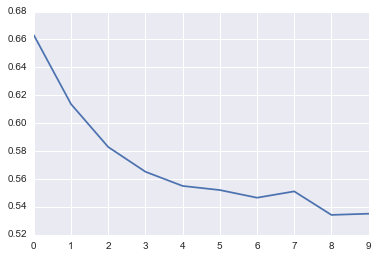

In [656]:
#We identify the number of clusters = 2 is the most optimal
def plot_silhouette_scores(data_set):
    s=[]
    for n_clusters in range(2,12):
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(data_set)
    
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
    
        s.append(silhouette_score(data_set,labels,metric='euclidean'))
    plt.plot(s)
    
X = nodes['revenueYear'].reshape(-1,1)

plot_silhouette_scores(X)
plt.savefig("silhoutte_score.png", bbox_inches="tight")

###### Actual creation of clusters(n=2) using k-means clustering

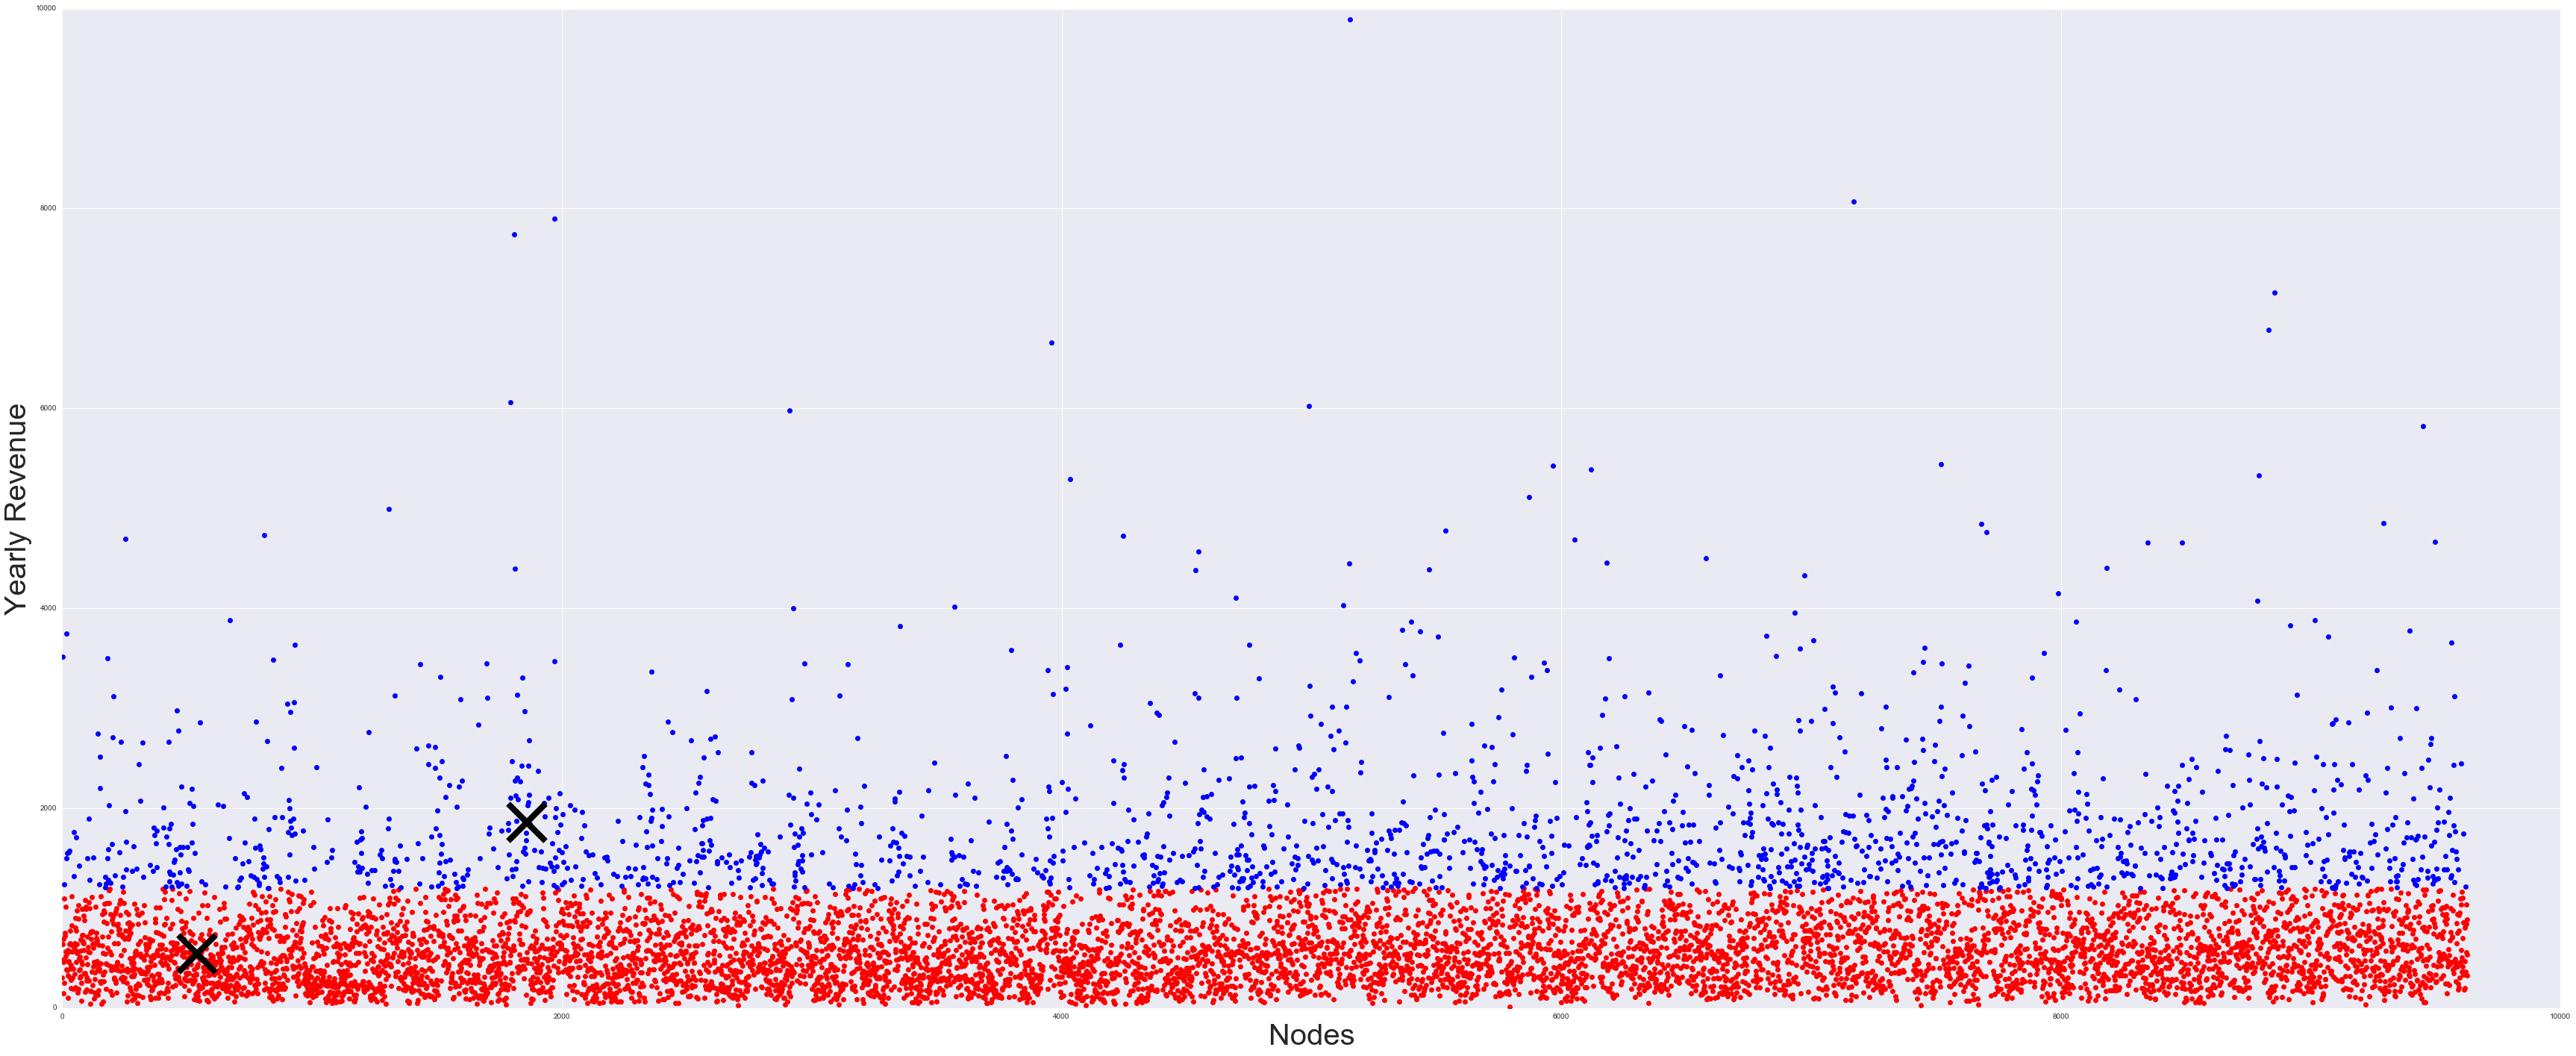

In [696]:
plt.clf()
plt.cla()

kmeans = KMeans(n_clusters=2, random_state=0).fit(list(nodes['revenueYear'].reshape(-1,1)))

nodes['kmeans_cluster'] = list(kmeans.labels_)

## Plot cluster centroids
labels = kmeans.labels_
centroid = kmeans.cluster_centers_


for i in range(2):        
    # plot observations
    if i==0:
        plt.plot(nodes['revenueYear'][labels==i],'ro')
    elif i==1:
        plt.plot(nodes['revenueYear'][labels==i],'bo')
    else:
        plt.plot(nodes['revenueYear'][labels==i],'go')
        
    # plot centroid
    lines = plt.plot(centroid[i,0],centroid[i,0],'kx')
    # make the centroid x's bigger
    plt.setp(lines,ms=50.0)
    plt.setp(lines,mew=8.0)
    plt.xlabel('Nodes', fontsize=40)
    plt.ylabel('Yearly Revenue', fontsize=40)

pylab.rcParams['figure.figsize'] = (60, 24) 
plt.savefig("Clusters.png", bbox_inches="tight")
plt.show()

###### Finding the % 'Revenue Similarity' of each node with its friends (We name it 'revenue_similarity')

In [333]:
revenue_similarity = [0]* len(nodes)
for i,friends in enumerate(nodes['friends_names']):
    if type(friends)!=type([1,2]):
        continue
    similarity = [0]*len(friends)
    for j,friend in enumerate(friends):
        if (nodes['kmeans_cluster'][friend-1] == nodes['kmeans_cluster'][i]):
            similarity[j] = 1
    percentage_similarity = sum(similarity)/len(similarity)
    revenue_similarity[i] = percentage_similarity
    
nodes['revenue_similarity']=revenue_similarity

###### Plotting the 'Revenue Similarity' based on each cluster (0 and 1)

0.8171120271401366
0.38441644377128276


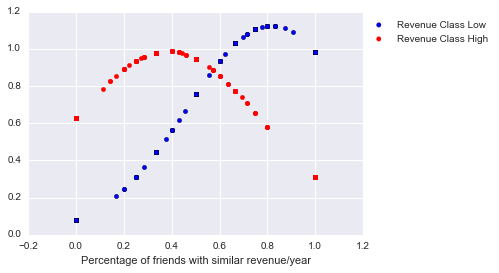

In [655]:
x = nodes['revenue_similarity'][:4866][nodes['kmeans_cluster']==0]
plt.scatter(x, mlab.normpdf(x,mean(x),std(x)),label='Revenue Class Low')
y = nodes['revenue_similarity'][:4866][nodes['kmeans_cluster']==1]
plt.scatter(y, mlab.normpdf(y,mean(y),std(y)), color='red', label='Revenue Class High')
plt.xlabel('Percentage of friends with similar revenue/year')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.savefig("RevenueSimilarityCluster.png", bbox_inches="tight")


print (mean(x))
print (mean(y))
    

###### #Finding the % similarity of each node's number of friends with their friends' number of friends. (We name it 'numberoffriends_similarity')

In [617]:
#Finding the % similarity of each node's number of friends with their friends' number of friends.

friends_similarity = [NaN]*len(nodes)
for i,friends in enumerate(nodes['friends_names'][:4866]):
    if type(friends)!=type([1,2]):
        continue
    similarity = []
    for j,friend in enumerate(friends):
        if friend>4866:
            continue
        elif (abs(nodes['friends'][friend-1] - nodes['friends'][i])<=2): 
            similarity.append(1)
        elif (abs(nodes['friends'][friend-1] - nodes['friends'][i])>2): 
            similarity.append(0)
    percentage_similarity = sum(similarity)/len(similarity)
    friends_similarity[i] = percentage_similarity
    
nodes['numberoffriends_similarity'] = friends_similarity

###### Plotting the 'Number of Friends Similarity' based on each cluster (0 and 1)

0.8684123847167325
0.6853591160220993


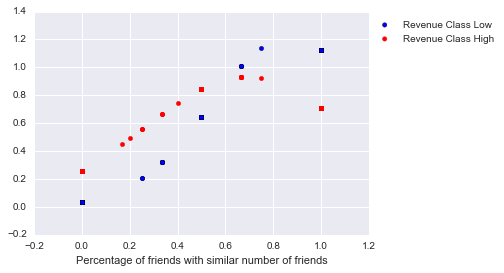

In [631]:
#Shows that overall there is a lot of friends similarity

plt.clf()
x = nodes['numberoffriends_similarity'][:4866][nodes['kmeans_cluster']==0]
plt.scatter(x, mlab.normpdf(x,mean(x),std(x)),label='Revenue Class Low')
y = nodes['numberoffriends_similarity'][:4866][nodes['kmeans_cluster']==1]
plt.scatter(y, mlab.normpdf(y,mean(y),std(y)), color='red', label='Revenue Class High')
plt.xlabel('Percentage of friends with similar number of friends')
plt.legend(bbox_to_anchor=(1.4, 1))

plt.savefig("FriendsSimilarityCluster.png", bbox_inches="tight")


print (mean(x))
print (mean(y))

### Finding the 'Average network size' and 'Average revenue in hand' for lower income and higher income clusters

In [546]:
print (mean(nodes[nodes['kmeans_cluster']==0]['network_size']))

print (mean(nodes[nodes['kmeans_cluster']==1]['network_size']))

print (mean(nodes[:4866][nodes['kmeans_cluster']==0]['revenue_in_hand']))

print (mean(nodes[:4866][nodes['kmeans_cluster']==1]['revenue_in_hand']))

5.293928479547208
9.14185544768069
1720.1067147396695
4583.285083870968


/Users/shirishdhar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/shirishdhar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Finding the most integral nodes by first-layer sorting based on network size and second-layer sorting based on revenue in hand 

In [7]:
nodes.sort(['network_size','revenue_in_hand'],ascending=False).head()

/Users/shirishdhar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,node,revenueYear,weight,friends,average_strength,friends_names,average_friends_revenues,zips,average_friends_friends,total_friends_revenues,revenue_in_hand,revenue_bins,friends_revenue_bins,revenue_similarity,kmeans_cluster,centrality,network_size,numberoffriends_similarity
2925,2926,4003.72,67,13,5.153846,"[1510, 5030, 3552, 4766, 5899, 7852, 7853, 785...",1339.247692,98119,5.20,17410.22,21413.94,4,4,0.461538,1,0.000045,88,0.000000
2927,2928,2102.72,57,9,6.333333,"[1510, 3552, 1563, 6487, 5899, 2926, 925, 6850...",1729.868889,98119,6.40,15568.82,17671.54,4,4,0.666667,1,0.000044,88,0.200000
1509,1510,2309.02,51,8,6.375000,"[3552, 6466, 5899, 2926, 925, 2928, 6467, 6468]",1514.258750,98109,7.75,12114.07,14423.09,4,4,0.500000,1,0.000003,88,0.500000
3551,3552,800.40,39,6,6.500000,"[1510, 5899, 2926, 2928, 5726, 6468]",2088.043333,98125,10.00,12528.26,13328.66,3,4,0.166667,0,0.000009,88,0.333333
1814,1815,1098.60,50,10,5.000000,"[5030, 6771, 6772, 4714, 3148, 6773, 6774, 233...",1189.914000,98112,5.00,11899.14,12997.74,4,4,0.700000,0,0.000011,88,0.000000


# End of code